# DeepDream with Inception V3 Model

####Preparations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import PIL.Image
from IPython.display import display
import os, sys
from datetime import datetime

class ColabIO:
  def __init__(self, base):
    self.BASE_PATH = base
    self.INPUT_PATH = os.path.join(BASE_PATH, 'input')
    self.OUTPUT_PATH = os.path.join(BASE_PATH, 'output')
    self.MAX_DIM = 500

  def load_img(self, filename):
    '''
    filepath  -- str

    returns   -- np.ndarray
    '''
    filepath = os.path.join(self.INPUT_PATH, filename)
    try:
      img = PIL.Image.open(filepath).convert("RGB")
    except:
      print("cannot to load " + filepath)
    if self.MAX_DIM:
        img.thumbnail((self.MAX_DIM, self.MAX_DIM))
    img = np.array(img)
    print("input shape:\t " + str(img.shape))
    return np.array(img, dtype=float)

  def save_img(self, image, suffix=None):
    '''
    image     -- np.ndarray
    filepath  -- str

    returns   -- np.ndarray
    '''
    if isinstance(suffix, str):
      filename = datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + suffix
    else:
      assert isinstance(suffix, str)
      filename = datetime.now().strftime("%Y%m%d-%H%M%S")
    
    filepath = os.path.join(self.OUTPUT_PATH, filename)
    img = np.clip(image, 0, 255).astype('uint8')
    
    try:
      PIL.Image.fromarray(img).save(filepath)
      if os.path.exists(filepath):
        print("output saved: " + filename)
    except IOError:
      print("cannot save ", filepath)

  def show_img(self, image):
    '''
    img       -- np.ndarray
    '''
    img = np.clip(image, 0, 255).astype('uint8')
    print("(type, shape):\t(" + str(type(img)) + ", " + str(img.shape) + ")")
    display(PIL.Image.fromarray(img))

  def get_input_dir(self):
    return pd.DataFrame({'Input Directory:':os.listdir(self.INPUT_PATH)})
  
  def get_output_dir(self):
    return pd.DataFrame({'Output Directory:':os.listdir(self.OUTPUT_PATH)})
  
  def get_io_dirs(self):
    return pd.concat([self.get_input_dir(), self.get_output_dir()], axis=1).replace(np.nan, '')

In [0]:
BASE_PATH = '/content/drive/My Drive/Colab Notebooks/deep_dream/'
io = ColabIO(BASE_PATH)

In [0]:
import numpy as np
import pandas as pd
from IPython.display import display

%load_ext tensorboard
import tensorflow as tf
import tensorboard

####Image Processing

In [0]:
def preprocess(image):
  ''' The model was trained on normalized images.
  image     --  np.ndarray

  returns   --  tf.Tensor
  '''
  img = tf.keras.applications.inception_v3.preprocess_input(image)
  return tf.convert_to_tensor(img, dtype=tf.float32)

def deprocess(image):
  img = 255*(image + 1.0)/2.0
  return tf.cast(img, tf.uint8).numpy()

def gaussian_filter(image, kernel_size=11, sigma=5.0):
  '''
  input         -- tf.Tensor
  kernel_size   -- tf.int32
  sigma         -- tf.float32

  returns       -- tf.Tensor
  '''
  def gauss_kernel(channels, kernel_size, sigma):
    ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
    xx, yy = tf.meshgrid(ax, ax)
    kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
    kernel = kernel / tf.reduce_sum(kernel)
    kernel = tf.expand_dims(kernel, axis=-1)
    kernel = tf.tile(kernel, [1, 1, channels])
    return kernel

  gaussian_kernel = gauss_kernel(tf.shape(image)[-1], kernel_size, sigma)
  gaussian_kernel = tf.expand_dims(gaussian_kernel, axis=-1)

  try:
    blurred = tf.nn.depthwise_conv2d(input=image, filter=gaussian_kernel, strides=[1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
  except:
    img_batch = tf.expand_dims(image, axis=0)
    blurred = tf.nn.depthwise_conv2d(input=img_batch, filter=gaussian_kernel, strides=[1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
  return tf.squeeze(blurred)

## future
def random_roll(image, maxroll):
  ''' To avoid tile seams.
  img       -- np.ndarray
  max       -- int

  returns   -- int, int, np.ndarray
  '''
  dx, dy = np.random.randint(low=-maxroll, high=maxroll, size=(2,))
  img_rolled = np.roll(np.roll(image, dy, axis=0), dx, axis=1)
  return dx, dy, img_rolled

def un_roll(image, dx, dy):
  return np.roll(np.roll(image, -dy, axis=0), -dx, axis=1)

## DeepDream Algorithm

In [0]:
def compute_cost(image):
  img = tf.expand_dims(image, axis=0)
  activations = model(img)

  layer_costs=[]
  for a in activations:
    a = tf.math.square(a)
    cost = tf.math.reduce_mean(a)
    layer_costs.append(cost)

  return tf.reduce_sum(layer_costs)

In [0]:
@tf.function(
    input_signature=(
      tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
      tf.TensorSpec(shape=[], dtype=tf.float32),
      tf.TensorSpec(shape=[], dtype=tf.int32))
)
def step(image, step_size, i):
  with tf.GradientTape() as g:
    g.watch(image)
    J = compute_cost(image)
  
  grad = g.gradient(J, image)
  
  N = tf.cast(PARAMS['num_iterations'], dtype=tf.float32)
  n = tf.cast(i, dtype=tf.float32)

  sigma =  n * 2.0 / N + 0.25
  grad_1 = gaussian_filter(grad, sigma=sigma)
  grad_2 = gaussian_filter(grad, sigma=sigma*2.0)
  grad_3 = gaussian_filter(grad, sigma=sigma*4.0)

  grad = (grad_1 + grad_2 + grad_3)
  
  step_size_scaled = step_size / (tf.math.reduce_std(grad) + tf.constant(1e-8))
  img = image + grad * step_size_scaled

  return img

In [0]:
def optimize_image(image, num_iterations, step_size):
  img = tf.identity(image)
  s = step_size
  ds = step_size/tf.cast(num_iterations, dtype=tf.float32)

  for i in tf.range(num_iterations):
    s -= ds
    img = step(img, s, i)
    
  return tf.clip_by_value(img, -1, 1)

In [0]:
def dream(image, num_iterations=10, octaves=4, scaling=0.7, blend=0.2, step_size=0.01):
  img = tf.identity(image)
  base_shape = tf.convert_to_tensor(image.shape[:-1], dtype=tf.int32)
  float_base_shape = tf.cast(base_shape, dtype=tf.float32)

  if octaves>0:
    img_blurred = gaussian_filter(img, 1.0)
    new_shape = tf.cast(float_base_shape*(scaling), dtype=tf.int32)
    img_scaled = tf.image.resize(img_blurred, new_shape)

    img_result = dream(img_scaled,
                       num_iterations=num_iterations, 
                       octaves=octaves-1, 
                       scaling=scaling, 
                       blend=blend, 
                       step_size=step_size)
  
    img_rescaled = tf.image.resize(img_result, base_shape)
    img = blend * img + (1.0 - blend) * img_rescaled

  img_result = optimize_image(img,
                              num_iterations=num_iterations,
                              step_size=step_size)
  
  return img_result

In [0]:
def run(filename, params):
  orig_image = io.load_img(filename)
  io.show_img(orig_image)

  orig_image = preprocess(orig_image)

  stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
  logdir = 'logs/func/%s' % stamp
  writer = tf.summary.create_file_writer(logdir)


  tf.summary.trace_on(graph=True, profiler=True)
  img = deprocess(dream(image=orig_image, **params))

  with writer.as_default():
    tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)


  io.show_img(img)
  io.save_img(img,  filename)

  return img

##Configuration & Model
####Choose image from input directory:

In [12]:
io_dirs = io.get_io_dirs()
display(io.get_io_dirs())

,Input Directory:,Output Directory:
0,IMG_3.jpg,
1,IMG_2.jpg,
2,IMG_1.jpg,
3,kanagawa.jpg,


In [13]:
index = 3
FILENAME = io_dirs.iat[index,0]
display("input image: " + FILENAME)

'input image: kanagawa.jpg'

####Load full inception model:

In [14]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
full_layer_list = [layer.name for layer in base_model.layers]
display(pd.DataFrame({'Layers': full_layer_list}))

,Layers
0,input_1
1,conv2d
2,batch_normalization
3,activation
4,conv2d_1
...,...
306,activation_85
307,mixed9_1
308,concatenate_1
309,activation_93


Choose output layers from list:

In [0]:
layer_names = [
               #'mixed0',
               #'mixed1',
               #'mixed2',
               'mixed3',
               #'mixed4', 
               #'mixed5',
               #'mixed6', 
               'mixed7'#, 
               #'mixed8', 
               #'mixed9', 
               #'mixed10'
               ]

layers = [base_model.get_layer(name).output for name in layer_names]
model = tf.keras.Model(inputs=base_model.input, outputs=layers)

####Choose dreaming parameters:

In [0]:
PARAMS_VALS = {
    'num_iterations': 10, 
    'octaves': 4, 
    'scaling': 0.7, 
    'blend': 0.2, 
    'step_size': 0.05
    }

PARAMS = dict([(key, tf.convert_to_tensor(val)) for key, val in PARAMS_VALS.items()])

##Application

In [17]:
print("input file:\t" + str(FILENAME))
print("parameters:\t" + str(PARAMS_VALS))
print("layers:\t\t" + str(layer_names))

input file:	kanagawa.jpg
parameters:	{'num_iterations': 10, 'octaves': 4, 'scaling': 0.7, 'blend': 0.2, 'step_size': 0.05}
layers:		['mixed3', 'mixed7']


input shape:	 (353, 500, 3)
(type, shape):	(<class 'numpy.ndarray'>, (353, 500, 3))


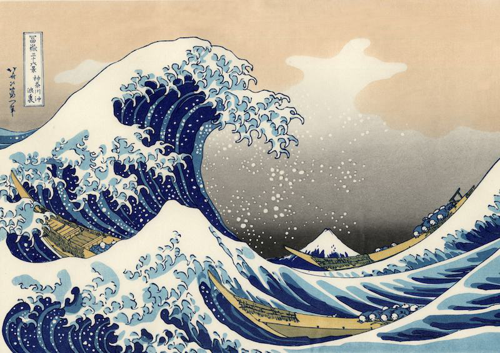

(type, shape):	(<class 'numpy.ndarray'>, (353, 500, 3))


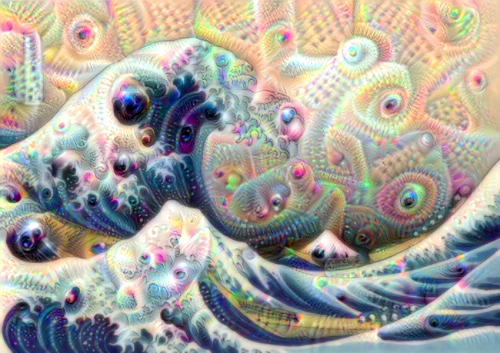

output saved: 20200515-042935_kanagawa.jpg


In [18]:
result = run(FILENAME, PARAMS)

In [19]:
%tensorboard --logdir logs/func

Reusing TensorBoard on port 6006 (pid 5987), started 0:52:37 ago. (Use '!kill 5987' to kill it.)

<IPython.core.display.Javascript object>